## 1. 필요한 패키지 로드

In [1]:
# Local Feature Stencil Code
# Written by James Hays for CS 143 @ Brown / CS 4476/6476 @ Georgia Tech with Henry Hu <henryhu@gatech.edu>
# Edited by James Tompkin
# Adapted for python by asabel and jdemari1 (2019)
# Modified by Soochahn Lee for Computer Vision coarse, School of Electrical Engineering, Kookmin University

import csv
import sys
import argparse
import numpy as np
import scipy.io as scio

import matplotlib
#matplotlib.use("TkAgg")
%matplotlib inline
import matplotlib.pyplot as plt

from skimage import io, filters, feature, img_as_float32
from skimage.transform import rescale
from skimage.color import rgb2gray

import student as student
import visualize
from helpers import cheat_interest_points, evaluate_correspondence

## 2. 실험용 데이터 파일 로딩 함수 정의

해당 함수는 실험용 영상의 쌍을 읽어들이고 적절하게 포맷을 조정하는 코드와, 해당 영상 쌍에 대한 특징점 정합의 참값 데이터를 읽어들이는 코드로 구성됨

In [2]:
# This function loads preassigned images and data for test cases
def load_data(file_name):
    """
     1) Load stuff
     There are numerous other image sets in the supplementary data on the
     project web page. You can simply download images off the Internet, as
     well. However, the evaluation function at the bottom of this script will
     only work for three particular image pairs (unless you add ground truth
     annotations for other image pairs). It is suggested that you only work
     with the two Notre Dame images until you are satisfied with your
     implementation and ready to test on additional images. A single scale
     pipeline works fine for these two images (and will give you full credit
     for this project), but you will need local features at multiple scales to
     handle harder cases.

     If you want to add new images to test, create a new elif of the same format as those
     for notre_dame, mt_rushmore, etc. You do not need to set the eval_file variable unless
     you hand create a ground truth annotations. To run with your new images use
     python main.py -p <your file name>.

    :param file_name: string for which image pair to compute correspondence for

        The first three strings can be used as shortcuts to the
        data files we give you

        1. notre_dame
        2. mt_rushmore
        3. e_gaudi

    :return: a tuple of the format (image1, image2, eval file)
    """
    # Note: these files default to notre dame, unless otherwise specified
    image1_file = "../data/NotreDame/NotreDame1.jpg"
    image2_file = "../data/NotreDame/NotreDame2.jpg"

    eval_file = "../data/NotreDame/NotreDameEval.mat"

    if file_name == "notre_dame":
        pass
    elif file_name == "mt_rushmore":
        image1_file = "../data/MountRushmore/Mount_Rushmore1.jpg"
        image2_file = "../data/MountRushmore/Mount_Rushmore2.jpg"
        eval_file = "../data/MountRushmore/MountRushmoreEval.mat"
    elif file_name == "e_gaudi":
        image1_file = "../data/EpiscopalGaudi/EGaudi_1.jpg"
        image2_file = "../data/EpiscopalGaudi/EGaudi_2.jpg"
        eval_file = "../data/EpiscopalGaudi/EGaudiEval.mat"

    image1 = img_as_float32(io.imread(image1_file))
    image2 = img_as_float32(io.imread(image2_file))

    return image1, image2, eval_file

## 3. 실험용 영상 설정 

본 notebook에서 아래 셀은 학생 여러분이 직접 아래 세 가지 중 입력을 하도록 변경해야 함
   1. notre_dame
   2. mt_rushmore
   3. e_gaudi

반드시 영상 쌍을 세 종류 모두에 대해 실험하고 결과를 도출하도록 함

In [3]:
# (0) SET TEST PAIR NAME
#   EITHER "notre_dame", "mt_rushmore", or "e_gaudi"
pair_name = "notre_dame"  # <-- YOU CAN CHANGE THIS

## 4. 영상 로드

In [4]:
# (1) Load and resizes images
image1_color, image2_color, eval_file = load_data(pair_name)

# Let's work with grayscale images.
image1 = rgb2gray(image1_color)
image2 = rgb2gray(image2_color)

# make images smaller to speed up the algorithm. This parameter
# gets passed into the evaluation code, so don't resize the images
# except for changing this parameter - We will evaluate your code using
# scale_factor = 0.5, so be aware of this
scale_factor = 0.5

# Bilinear rescaling
image1 = np.float32(rescale(image1, scale_factor))
image2 = np.float32(rescale(image2, scale_factor))

# width and height of each local feature, in pixels
feature_width = 16

## 5. 특징점 도출

Getting interest points...


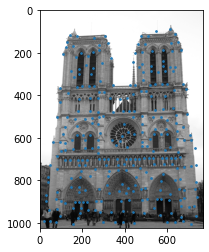

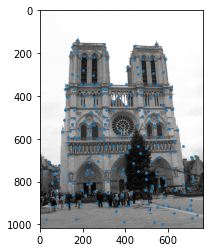

Done!


In [5]:
# (you code this)
# (2) Find distinctive points in each image. See Szeliski 4.1.1
# !!! You will need to implement get_interest_points. !!!

print("Getting interest points...")

kpts1 = student.get_interest_points(image1,feature_width)
kpts2 = student.get_interest_points(image2,feature_width)

# For development and debugging you can compare with the ta ground truth points
# by uncommenting the following lines.
# Note that the ground truth points for mt. rushmore will not produce good results.

# (x1, y1, x2, y2) = cheat_interest_points(eval_file, scale_factor)

# view your corners!

plt.imshow(image1, cmap="gray")
plt.scatter(kpts1[:,0], kpts1[:,1], alpha=0.9, s=3)
plt.show()

plt.imshow(image2, cmap="gray")
plt.scatter(kpts2[:,0], kpts2[:,1], alpha=0.9, s=3)
plt.show()

print("Done!")

## 6. 특징 기술자 생성

In [6]:
# 3) Create SIFT feature vectors at each interest point using OpenCV
import cv2 as cv

image1_norm = cv.normalize(image1, None, 0, 255, cv.NORM_MINMAX).astype('uint8')
image2_norm = cv.normalize(image2, None, 0, 255, cv.NORM_MINMAX).astype('uint8')

print("Getting SIFT features...")

print(kpts1)
print(kpts2)
kpt_patch_sz = 15
cv_kpts1 = [cv.KeyPoint(float(kpts1[i,0]), float(kpts1[i,1]), kpt_patch_sz) for i in range(kpts1.shape[0])]
cv_kpts2 = [cv.KeyPoint(float(kpts2[i,0]), float(kpts2[i,1]), kpt_patch_sz) for i in range(kpts2.shape[0])]
# compute the SIFT descriptors from the Harris Corner keypoints 
sift = cv.SIFT_create()
cv_kpts1, desc1 = sift.compute(image1_norm, cv_kpts1)
cv_kpts2, desc2 = sift.compute(image2_norm, cv_kpts2)
# img1 = cv.drawKeypoints(image1, cv_kpts1, image1)
# img2 = cv.drawKeypoints(image2, cv_kpts2, image2)

print("Done!")

Getting SIFT features...
[[ 690  372]
 [ 674  345]
 [ 411  414]
 [ 691  486]
 [ 380  416]
 [ 346  353]
 [ 427  351]
 [  95  364]
 [ 345  478]
 [ 665  184]
 [ 613   86]
 [ 176  119]
 [  81  500]
 [ 476  118]
 [ 334  226]
 [ 390  998]
 [ 713  610]
 [ 450  351]
 [ 394  475]
 [ 124  172]
 [ 308  122]
 [ 322  155]
 [  47  726]
 [ 154 1007]
 [ 734  810]
 [ 438  243]
 [ 143  117]
 [  50  992]
 [  19  992]
 [  41  941]
 [ 636  997]
 [ 543  469]
 [ 445  474]
 [ 110  203]
 [ 450  201]
 [ 480  496]
 [ 628  460]
 [ 651  148]
 [ 637  111]
 [  96  966]
 [ 665  973]
 [ 568  963]
 [ 184  416]
 [ 708  587]
 [ 675  993]
 [ 235  414]
 [ 461  157]
 [ 442  999]
 [ 590  405]
 [ 420  475]
 [ 284  951]
 [ 355  996]
 [ 129  149]
 [ 359  634]
 [ 410  641]
 [ 642  493]
 [ 661  692]
 [ 634  374]
 [  80  935]
 [ 581  187]
 [  76  998]
 [  61  621]
 [ 297  996]
 [ 376  614]
 [ 528  189]
 [ 493  954]
 [  81  684]
 [ 236  472]
 [ 296  499]
 [ 330  411]
 [ 232  357]
 [ 272  645]
 [ 184  904]
 [ 121  705]
 [ 164  904]


## 7. RANSAC을 이용한 특징점 정합

In [7]:
# (you code this)
# 4) Match features.
# !!! You will need to implement match_features_nn(), match_features_ransac() !!!

print("Matching nearest neighbor features...")
matches, confidences = student.match_features_nn(desc1, desc2)
print("Matching inlier features using RANSAC...")
matches_in, H = student.match_features_ransac(kpts1, kpts2, matches)

print("Done!")

Matching nearest neighbor features...
Matching inlier features using RANSAC...
Done!


## 8. 계산된 homography를 이용하여 정렬된 영상 생성 

Generating aligned image...
Done!


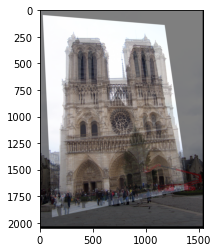

In [10]:
# (you code this)
# 6) Generate aligned image.
# !!! You will need to implement get_aligned_image() !!!

print("Generating aligned image...")
aligned_image = student.get_aligned_image(image1_color, image2_color, H)

# show and save generated image
plt.imshow(aligned_image)
cv.imwrite("aligned_image.png", aligned_image)

print("Done!")

## 9. 참값 데이터를 기반으로 도출된 결과의 성능 검증

Matches: 50
Accuracy on 50 most confident: 88%
Accuracy on all matches: 88%
Vizualizing...


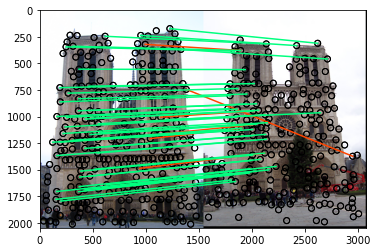

(44, 0, 44)

In [11]:
# 5) Evaluation and visualization

# The last thing to do is to check how your code performs on the image pairs
# we've provided. The evaluate_correspondence function below will print out
# the accuracy of your feature matching for your 50 most confident matches,
# 100 most confident matches, and all your matches. It will then visualize
# the matches by drawing green lines between points for correct matches and
# red lines for incorrect matches. The visualizer will show the top
# num_pts_to_visualize most confident matches, so feel free to change the
# parameter to whatever you like.

print("Matches: " + str(matches.shape[0]))

num_pts_to_visualize = 50

evaluate_correspondence(image1_color, image2_color, eval_file, scale_factor,
    kpts1[:,0], kpts1[:,1], kpts2[:,0], kpts2[:,1], matches, confidences, num_pts_to_visualize, pair_name + '_matches.jpg')